<a href="https://colab.research.google.com/github/FrancescoPetri/Topology_COVID/blob/main/Non_markov_SIR_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Import libraries (including Epidemics on Networks - EoN)
!pip install EoN
import networkx as nx
import matplotlib.pyplot as plt
import EoN
import random
from random import sample
import ipywidgets as widgets


from operator import itemgetter
import networkx.linalg
from datetime import datetime

In [2]:
#@title Simulation code
def trans_time_fxn(source, target, rate):
    return random.expovariate(rate)

def rec_time_fxn(node,D):
    return D

def fast_nonMarkov_SIR_full_data(graph, transmission_rate, recovery_rate, tsim_max, infected_num=None, recovered_num=None, tstart = 0):
    G = graph
  #  rho = ratio_infected             # initial fraction infected
    infected_nodes = infected_num    # index of infected nodes
    recovered_nodes = recovered_num  # index of recovedred nodes
    tau = transmission_rate          # transmission rate
    gamma = recovery_rate            # recovery rate
    max_sim_time = tsim_max          # maximum simulation time
    D=14

    print("doing Event-driven simulation")
    full_data = EoN.fast_nonMarkov_SIR(G, trans_time_fxn=trans_time_fxn, rec_time_fxn=rec_time_fxn, trans_time_args=(tau,), rec_time_args=(D,), tmin=tstart, tmax = max_sim_time, initial_infecteds=infected_nodes, initial_recovereds=recovered_nodes, return_full_data = True)

    return full_data
def simulation_loop(G, toberemoved_nodes, transmission_rate, recovery_rate, tsim_max, init_infected):

    #@markdown Choose a vaccination strategy
    metrics = "betweenness" #@param ["betweenness", "degree","eigenvector"]

    degree_dict=dict(G.degree(G.nodes()))
# arricchimento del grafo con le informazioni su centralita' dei vari nodi
    if metrics=="betweenness":
        betweenness_dict=nx.betweenness_centrality(G) # eigenvector centrality, closeness centrality
        nx.set_node_attributes(G, betweenness_dict, 'betweenness')
        sorted_betweenness=sorted(betweenness_dict.items(), key=itemgetter(1),reverse=True)
    elif metrics=="degree":
        sorted_degree= sorted(degree_dict.items(), key=itemgetter(1),reverse=True)
        sorted_degree_rev= sorted(degree_dict.items(), key=itemgetter(1),reverse=False)
        nx.set_node_attributes(G, sorted_degree, 'degree')
    elif metrics=="eigenvector":
        eigenvector_dict=nx.eigenvector_centrality(G)
        nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')
        sorted_eigenvector=sorted(eigenvector_dict.items(),key=itemgetter(1),reverse=True)

    vaccination_time  = 2 #@param {type:"number"}
    trigger_time = int(tsim_max - vaccination_time)

    # define random initial infected nodes
    ratio = (G.number_of_nodes())*init_infected
    init_infected_nodes = sample(list(G.nodes()), int(ratio))
    print('Number of initial infected nodes: {}'.format(len(init_infected_nodes)))

    # Original graph ---------------------------------------------
    print('Original graph')
    maxautovaloreoriginale=max(nx.linalg.adjacency_spectrum(G))
    # start simulation - full data 
    # t, S, I
    # res_orig = fast_SIS(G, init_infected, transmission_rate, recovery_rate, tsim_max)
    res_orig_before = fast_nonMarkov_SIR_full_data(G, transmission_rate, recovery_rate, tsim_max - trigger_time, infected_num=init_infected_nodes)
    ## get the node statuses at trigger time
    res_orig_before_status = res_orig_before.get_statuses(time=tsim_max - trigger_time)
    Snodes = [k for k,v in res_orig_before_status.items() if v == 'S']
    Inodes = [k for k,v in res_orig_before_status.items() if v == 'I']
    Rnodes = [k for k,v in res_orig_before_status.items() if v == 'R']

    print('Number of S nodes before vaccination at time {}: {}'.format(tsim_max-trigger_time, len(Snodes)))
    print('Number of I nodes before vaccination at time {}: {}'.format(tsim_max-trigger_time, len(Inodes)))
    print('Number of R nodes before vaccination at time {}: {}'.format(tsim_max-trigger_time, len(Rnodes)))
    
    # restart with infected nodes without any vaccination strategy
    res_orig_after = fast_nonMarkov_SIR_full_data(G, transmission_rate, recovery_rate, tsim_max, infected_num=Inodes, recovered_num=Rnodes,  tstart=tsim_max - trigger_time)  
    res_orig = (list(res_orig_before.t())+list(res_orig_after.t()[1:]), 
               list(res_orig_before.S())+list(res_orig_after.S()[1:]),
               list(res_orig_before.I())+list(res_orig_after.I()[1:]),
               list(res_orig_before.R())+list(res_orig_after.R()[1:]))
    
    res_orig_after_status = res_orig_after.get_statuses(time=tsim_max)
    Snodes_res_orig_after = [k for k,v in res_orig_after_status.items() if v == 'S']
    Inodes_res_orig_after = [k for k,v in res_orig_after_status.items() if v == 'I']
    Rnodes_res_orig_after = [k for k,v in res_orig_after_status.items() if v == 'R']

    print('Final number of S nodes without vaccination: {}'.format(len(Snodes_res_orig_after)))
    print('Final number of I nodes without vaccination: {}'.format(len(Inodes_res_orig_after)))
    print('Final number of R nodes without vaccination: {}'.format(len(Rnodes_res_orig_after)))   
   
    print(nx.info(G)+"\n")
    print('\n')   
  

    # Controlled vaccination -----------------------------------------------
    tobevaccinated= list()
    Gcopia=nx.Graph()
    Gcopia.add_edges_from(G.edges())
    
    if metrics=="betweenness":
      sorted_betweenness = [x for x in sorted_betweenness if x[0] not in Inodes]
      for d in sorted_betweenness[:tobevaccinated_nodes]:
          tobevaccinated.append(d[0])
    if metrics=="degree":
      sorted_degree = [x for x in sorted_degree if x[0] not in Inodes]
      for d in sorted_degree[:tobevaccinated_nodes]:
          tobevaccinated.append(d[0])
    if metrics=="eigenvector":
      sorted_eigenvector = [x for x in sorted_eigenvector if x[0] not in Inodes]
      for d in sorted_eigenvector[:tobevaccinated_nodes]:
          tobevaccinated.append(d[0])
 
    print ("Controlled vaccination")
    Gcopia.remove_nodes_from(tobevaccinated)
    maxAutovalorepruned=max(nx.linalg.adjacency_spectrum(Gcopia))

    #Nodes to be vaccinated 
    print("vaccinated nodes: {}".format(tobevaccinated))

  #  Rnodes_union  = list(set(Rnodes).union(tobevaccinated))
    print('Number of S nodes vaccinated at time {}: {}'.format(tsim_max-trigger_time, len(set(Snodes).intersection(tobevaccinated))))
    print('Number of I nodes vaccinated at time {}: {}'.format(tsim_max-trigger_time, len(set(Inodes).intersection(tobevaccinated))))
    print('Number of R nodes after vaccination at time {}: {}'.format(tsim_max-trigger_time, len(Rnodes)))
    print('\n')   
    Inodes  = list(set(Inodes).difference(tobevaccinated))
    # t, S, I
    # restart with infected nodes with controlled vaccination strategy
    res_pruned_after = fast_nonMarkov_SIR_full_data(Gcopia, transmission_rate, recovery_rate, tsim_max, infected_num=Inodes, recovered_num=Rnodes, tstart=tsim_max - trigger_time)
    print(nx.info(Gcopia)+"\n")

    res_fly = (list(res_orig_before.t())+list(res_pruned_after.t()[1:]), 
               list(res_orig_before.S())+list(res_pruned_after.S()[1:]),
               list(res_orig_before.I())+list(res_pruned_after.I()[1:]),
               list(res_orig_before.R())+list(res_pruned_after.R()[1:]))

    res_pruned_after_status = res_pruned_after.get_statuses(time=tsim_max)
    Snodes_res_pruned_after = [k for k,v in res_pruned_after_status.items() if v == 'S']
    Inodes_res_pruned_after = [k for k,v in res_pruned_after_status.items() if v == 'I']
    Rnodes_res_pruned_after = [k for k,v in res_pruned_after_status.items() if v == 'R']

    print('Final number of S nodes after controlled vaccination: {}'.format(len(Snodes_res_pruned_after)))
    print('Final number of I nodes after controlled vaccination: {}'.format(len(Inodes_res_pruned_after)))
    print('Final number of R nodes after controlled vaccination: {}'.format(len(Rnodes_res_pruned_after)))   
    print('\n')   


    # Random vaccination ------------------------------------------------
    tobevaccinatedrnd = list()
    Grnd=nx.Graph()
    Grnd.add_edges_from(G.edges())

    print ("Randomly pruned graph")
    
    tobevaccinatedrnd = random.sample(Snodes,tobevaccinated_nodes)

    Grnd.remove_nodes_from(tobevaccinatedrnd)

    maxAutovalorernd=max(nx.linalg.adjacency_spectrum(Grnd))

    #Rnodes_union_rnd  = list(set(Rnodes).union(tobevaccinatedrnd))
    print('Number of S nodes vaccinated at time {}: {}'.format(trigger_time, len(set(Snodes).intersection(tobevaccinatedrnd))))
    print('Number of I nodes vaccinated at time {}: {}'.format(trigger_time, len(set(Inodes).intersection(tobevaccinatedrnd))))
    print('Number of R nodes after vaccination at time {}: {}'.format(trigger_time, len(Rnodes)))
    # t, S, I
    # restart with infected nodes with random vaccination strategy
    res_rnd_after = fast_nonMarkov_SIR_full_data(Grnd, transmission_rate, recovery_rate, tsim_max, infected_num=Inodes, recovered_num=Rnodes, tstart=tsim_max - trigger_time)

    res_rnd_after_status = res_rnd_after.get_statuses(time=tsim_max)
    Snodes_res_rnd_after = [k for k,v in res_rnd_after_status.items() if v == 'S']
    Inodes_res_rnd_after = [k for k,v in res_rnd_after_status.items() if v == 'I']
    Rnodes_res_rnd_after = [k for k,v in res_rnd_after_status.items() if v == 'R']

    print('Final number of S nodes after random vaccination: {}'.format(len(Snodes_res_rnd_after)))
    print('Final number of I nodes after random vaccination: {}'.format(len(Inodes_res_rnd_after)))
    print('Final number of R nodes after random vaccination: {}'.format(len(Rnodes_res_rnd_after)))   
    print('\n') 

    print(nx.info(Grnd)+"\n")



    res_rnd = (list(res_orig_before.t())+list(res_rnd_after.t()[1:]), 
               list(res_orig_before.S())+list(res_rnd_after.S()[1:]),
               list(res_orig_before.I())+list(res_rnd_after.I()[1:]),
               list(res_orig_before.R())+list(res_rnd_after.R()[1:]))     
    print(res_rnd[0])

    #return (maxautovaloreoriginale, maxAutovalorepruned, maxAutovalorernd, res_orig, res_fly, res_rnd, tobevaccinatedrnd, tobevaccinated, tobevaccinated_betweenness, tobevaccinated_eigenvector )
    return (maxautovaloreoriginale, maxAutovalorepruned, maxAutovalorernd, res_orig, res_fly, res_rnd, tobevaccinatedrnd, tobevaccinated )

In [5]:
#@title 
#@markdown Define the  network properties
#@markdown ---
network = "duplication_divergence_graph" #@param ["duplication_divergence_graph", "fast_gnp_random_graph","barabasi_albert_graph","gnp_random_graph"]
#initial population
init_population = 1000 #@param {type:"number"}
#number of expected partners
exp_partners = 5 #@param {type:"number"}
#percentage of initial population infected
init_infected = 0.005 #@param {type:"number"}

#@markdown Simulation parameters
#@markdown ---
transmission_rate = 0.4 #@param {type:"number"}
recovery_rate = 1.0 #@param {type:"number"}
tsim_max =30 #@param {type:"number"}
sim_iterations =  1#@param {type:"number"}
tobevaccinated_nodes = 100 #@param {type:"number"}

now = datetime.now()
current_time = now.strftime("%H:%M:%S")

results=list()
if network=="duplication_divergence_graph":
  for i in range(sim_iterations):
      print('Start iteration '+ ' ' +str(i))
      print("Generating graph G with {} nodes".format(init_population))
      G = nx.duplication_divergence_graph(init_population, 0.4, seed=None)
      res = simulation_loop(G, tobevaccinated_nodes, transmission_rate, recovery_rate, tsim_max, init_infected)
      results.append(res)
elif network=="fast_gnp_random_graph":
  for i in range(sim_iterations):
      print('Start iteration '+ ' ' +str(i))
      print("Generating graph G with {} nodes".format(init_population))
      G = nx.fast_gnp_random_graph(init_population, exp_partners/(init_population-1)) #Erdos-Renyi graph
      res = simulation_loop(G, tobevaccinated_nodes, transmission_rate, recovery_rate, tsim_max, init_infected)
      results.append(res)
elif network=="barabasi_albert_graph":
  for i in range(sim_iterations):
      print('Start iteration '+ ' ' +str(i))
      print("Generating graph G with {} nodes".format(init_population))
      G = nx.barabasi_albert_graph(init_population, exp_partners)
      res = simulation_loop(G, tobevaccinated_nodes, transmission_rate, recovery_rate, tsim_max, init_infected)
      results.append(res)
elif network=="gnp_random_graph":
  for i in range(sim_iterations):
      print('Start iteration '+ ' ' +str(i))
      print("Generating graph G with {} nodes".format(init_population))
      G = nx.generators.random_graphs.gnp_random_graph(init_population,0.4) 
      res = simulation_loop(G, tobevaccinated_nodes, transmission_rate, recovery_rate, tsim_max, init_infected)
      results.append(res)

print("Max autovalore originale: {}".format(results[0][0]))
print("Max autovalore pruned: {}".format(results[0][1]))
print("Max autovalore random: {}".format(results[0][2])) 

final = datetime.now()
final_time = final.strftime("%H:%M:%S")
print("End Time = {}".format(final - now))
print("done with simulations")


Start iteration  0
Generating graph G with 1000 nodes
Number of initial infected nodes: 5
Original graph
doing Event-driven simulation
Number of S nodes before vaccination at time 2: 432
Number of I nodes before vaccination at time 2: 568
Number of R nodes before vaccination at time 2: 0
doing Event-driven simulation
Final number of S nodes without vaccination: 0
Final number of I nodes without vaccination: 1
Final number of R nodes without vaccination: 999
Graph with 1000 nodes and 2619 edges



Controlled vaccination
vaccinated nodes: [461, 44, 83, 606, 204, 153, 649, 162, 159, 21, 25, 290, 62, 150, 233, 310, 492, 807, 294, 408, 156, 559, 576, 90, 925, 19, 485, 827, 219, 230, 379, 752, 690, 100, 858, 295, 354, 201, 410, 641, 826, 339, 901, 815, 790, 376, 872, 300, 795, 997, 761, 811, 856, 343, 91, 390, 34, 908, 322, 806, 833, 318, 542, 783, 350, 349, 654, 661, 442, 325, 347, 463, 789, 267, 968, 672, 664, 309, 333, 608, 499, 810, 798, 832, 67, 803, 316, 702, 361, 952, 109, 475, 694, 9

plotting - No vaccination strategy


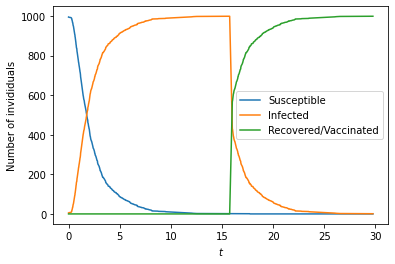

In [6]:
print("plotting - No vaccination strategy")

plt.plot(results[0][3][0], results[0][3][1], label = "Susceptible")
plt.plot(results[0][3][0], results[0][3][2], label = "Infected")
plt.plot(results[0][3][0], results[0][3][3], label = "Recovered/Vaccinated")
plt.xlabel("$t$")
plt.ylabel("Number of invididuals")
plt.legend()
plt.show()

plotting - Topology-based vaccination strategy


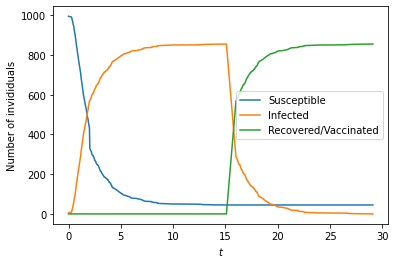

In [7]:
print("plotting - Topology-based vaccination strategy")

plt.plot(results[0][4][0], results[0][4][1], label = "Susceptible")
plt.plot(results[0][4][0], results[0][4][2], label = "Infected")
plt.plot(results[0][4][0], results[0][4][3], label = "Recovered/Vaccinated")
plt.xlabel("$t$")
plt.ylabel("Number of invididuals")
plt.legend()
plt.show()

plotting - Random vaccination strategy


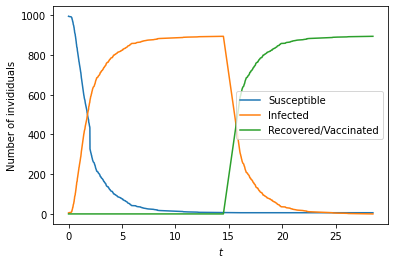

In [8]:
print("plotting - Random vaccination strategy")

plt.plot(results[0][5][0], results[0][5][1], label = "Susceptible")
plt.plot(results[0][5][0], results[0][5][2], label = "Infected")
plt.plot(results[0][5][0], results[0][5][3], label = "Recovered/Vaccinated")
plt.xlabel("$t$")
plt.ylabel("Number of invididuals")
plt.legend()
plt.show()

plotting


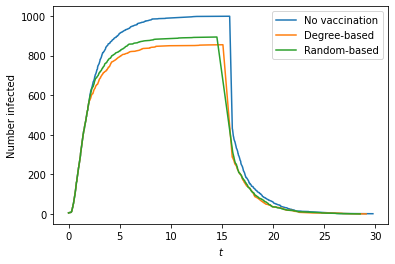

In [9]:
print("plotting")

plt.plot(results[0][3][0], results[0][3][2], label = "No vaccination")
plt.plot(results[0][4][0], results[0][4][2], label = "Degree-based")
plt.plot(results[0][5][0], results[0][5][2], label = "Random-based")
plt.xlabel("$t$")
plt.ylabel("Number infected")
plt.legend()
plt.show
plt.savefig("Degree_1.svg")
